<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/Qiskit_1_2_4_Introduction_mkbahk_20241013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install Qiskit

In [1]:
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-ibm-runtime==0.30.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=7111f057623b77322b5aa69c2ac0d2052839a92c8cd886920c2394f8e2805194
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

##Set up an IBM Quantum channel
00_start_qiskit_patterns_diagram.svg

In [ ]:
#from qiskit_ibm_runtime import QiskitRuntimeService
#service = QiskitRuntimeService(channel="ibm_quantum", token="56d517b9c8e16472af2d73eb795e32367a186f609dfa83496f7ff9d785df3aa222ca905e09d226505791c6ff53eca4a23114a35682875fa984edaf3fbec4fc06")

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="56d517b9c8e16472af2d73eb795e32367a186f609dfa83496f7ff9d785df3aa222ca905e09d226505791c6ff53eca4a23114a35682875fa984edaf3fbec4fc06",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

# Load saved credentials
service = QiskitRuntimeService()

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


In [6]:
print(service.backends())

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


In [4]:
#backend = service.backends()[0]
#print(backend)

<IBMBackend('ibm_brisbane')>


##Mapping the probem to Quantum Circuit
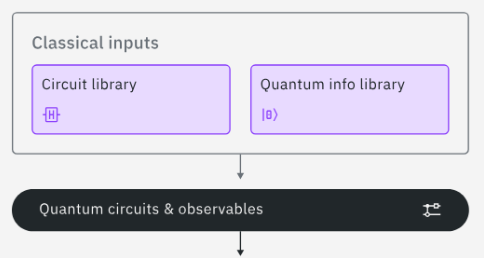

In [5]:
# Map problem to quantum circuits and operators:
# Import packages to build circuits

from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliTwoDesign
from qiskit.quantum_info import SparsePauliOp
import numpy as np


num_qubits=30
qc = PauliTwoDesign(num_qubits=num_qubits,reps=4, seed=5, insert_barriers=True)
parameters = qc.parameters


obs = SparsePauliOp.from_sparse_list([("Z", [num_qubits-2], 1)], num_qubits=num_qubits)


# Specify circuit parameter values
np.random.seed(0) # Specify the seed for debugging purpose such that the circuit is the same very time we run it
phi_max = 0.5 * np.pi
parameter_values = np.random.uniform(-1 * phi_max, phi_max, len(parameters))

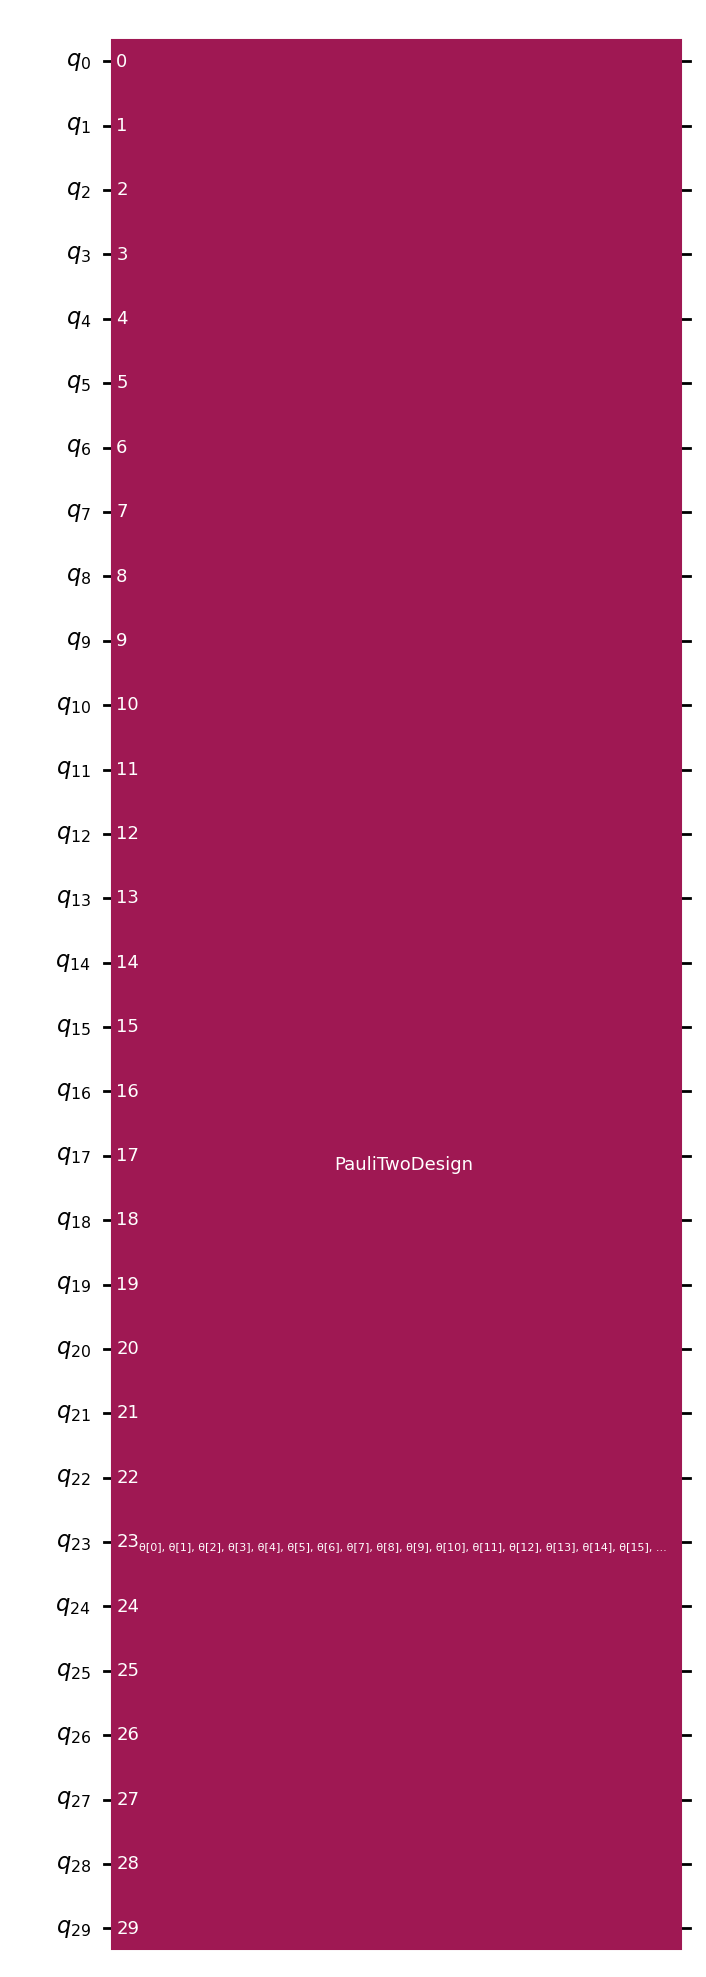

In [8]:
qc.draw("mpl")

##Optimize general circiut to the circuit of QPU specific

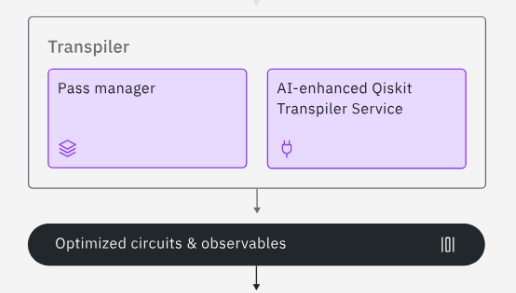

In [7]:
# Optimize for target hardware:

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager

backend = service.backend('ibm_sherbrooke')

target = backend.target

# Transpile the circuit
pm = generate_preset_pass_manager(
        target=target,
        optimization_level=3
      )

t_qc = pm.run(qc)

# Map the observables according to the transpile layout
t_obs = obs.apply_layout(t_qc.layout)

In [9]:
t_qc.draw("mpl")

## Execute the Circuit

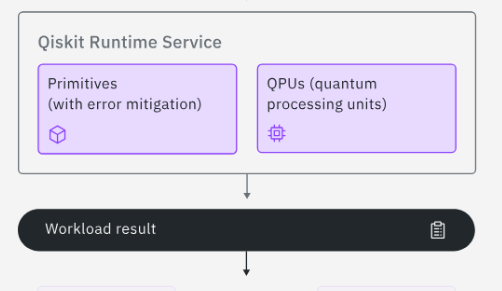

In [12]:
# Execute on target hardware:

from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions
from qiskit_ibm_runtime.options import DynamicalDecouplingOptions


dd_options = DynamicalDecouplingOptions(enable=True, sequence_type="XpXm")
options = EstimatorOptions(dynamical_decoupling=dd_options)

# For comparison, we first run circuit with non-optimized parameters
options.resilience_level = 0
options.default_precision = 1e-2

#estimator = EstimatorV2(backend=backend, options=options)
estimator = EstimatorV2(backend, options)
unoptimized_job = estimator.run([(t_qc, t_obs, parameter_values)])
print(unoptimized_job.job_id())

# Next we'll use resilience level 1 to add in more error mitigation
options = EstimatorOptions(dynamical_decoupling=dd_options)

options.resilience_level = 1
options.default_precision = 1e-2

#estimator = EstimatorV2(backend=backend, options=options)
estimator = EstimatorV2(backend, options)
optimized_job = estimator.run([(t_qc, t_obs, parameter_values)])
print(optimized_job.job_id())

# Finally we implement all available error mitigation techniques
# with resilience level 2
options = EstimatorOptions(dynamical_decoupling=dd_options)


options.resilience_level = 2
options.default_precision = 1e-2

#estimator = EstimatorV2(backend=backend, options=options)
estimator = EstimatorV2(backend, options)
fully_optimized_job = estimator.run([(t_qc, t_obs, parameter_values)])
print(fully_optimized_job.job_id())

cw5kxkyxa9wg0082qc90
cw5kxv719rzg008zrh10
cw5kxwqqg250008hzyy0


##Post-processing
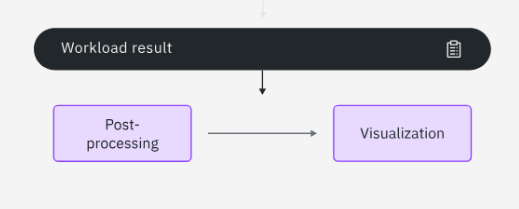

In [13]:
# Post-process results:

# Get unoptimized result and plot
unoptimized_result = unoptimized_job.result()
expectation_value_unoptimized = unoptimized_result[0].data.evs
expectation_value_unoptimized_stds = unoptimized_result[0].data.stds

# Get optimized result and plot
optimized_result = optimized_job.result()
expectation_value_optimized = optimized_result[0].data.evs
expectation_value_optimized_stds = optimized_result[0].data.stds

# Get optimized result and plot
fully_optimized_result = fully_optimized_job.result()
expectation_value_fully_optimized = fully_optimized_result[0].data.evs
expectation_value_fully_optimized_stds = fully_optimized_result[0].data.stds

print(f"Exact Expectation Value: 0.1484375")
print(f"Unoptimized Expectation Value: {expectation_value_unoptimized} ± {expectation_value_unoptimized_stds}")
print(f"Optimized Expectation Value: {expectation_value_optimized} ± {expectation_value_optimized_stds}")
print(f"Fully Optimized Expectation Value: {expectation_value_fully_optimized} ± {expectation_value_fully_optimized_stds}")

Exact Expectation Value: 0.1484375
Unoptimized Expectation Value: 0.0754 ± 0.00997153368344108
Optimized Expectation Value: 0.08662396323517839 ± 0.010187696236155246
Fully Optimized Expectation Value: 0.11984008993513383 ± 0.011246736354729447
